# Beer server, Pandas-style

### Oppa Pandas-style

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime as dt
%matplotlib inline

pd.set_option('display.max_rows', 200)

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Import files

In [2]:
beers = pd.read_csv('./Beers.csv', sep=';')
brands = pd.read_csv('./Brands.csv', sep=';')
taxonomy = pd.read_csv('./Beer_taxonomy.csv', sep=';')
regions = pd.read_csv('./Regions.csv', sep=';')
beers.set_index('RatingID', inplace=True)
beerskeep = ['BeerName', 'Brewery', 'Type', 'Origin', 'ABV', 'HowIDrank', 
             'TempIDrank', 'Taste', 'Aftertaste', 'MouthFeel', 'Rating',
             'Date']
beers = beers[beerskeep]
brandskeep = ['Brewery', 'Corporation']
brands = brands[brandskeep]

# FIXTHIS: Add some error handling to make sure there are no duplicates in taxo, brands, or regions

### Make the merged dataframes

In [3]:
# FIXTHIS: include some error checking for regions and taxo to be sure that all regions and taxonomies are covered
beers_regions = pd.merge(beers, regions, left_on='Origin', right_on='Region')
beers_taxo = pd.merge(beers, taxonomy, on='Type')
beers_corp = pd.merge(beers, brands, how='left', on='Brewery') # Only gives corp beers

# Knock out missing ratings
beers_regions = beers_regions[beers_regions['Rating'].notnull()]
beers_taxo = beers_taxo[beers_taxo['Rating'].notnull()]
beers_corp = beers_corp[beers_corp['Rating'].notnull()]

# let's stick everything in one big dataframe
beers_RTC = pd.merge(pd.merge(beers_regions, taxonomy, on='Type'), brands, how='left', on='Brewery')
# beers_RTC = beers_RTC[beers_RTC['Rating'].notnull()]

In [4]:
beers_RTC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 693 entries, 0 to 692
Data columns (total 19 columns):
BeerName       693 non-null object
Brewery        693 non-null object
Type           693 non-null object
Origin         693 non-null object
ABV            680 non-null float64
HowIDrank      689 non-null object
TempIDrank     688 non-null object
Taste          658 non-null object
Aftertaste     85 non-null object
MouthFeel      688 non-null object
Rating         693 non-null int64
Date           693 non-null object
Region         693 non-null object
Country        693 non-null object
Superregion    693 non-null object
Continent      693 non-null object
BeerClass      520 non-null object
AleOrLager     693 non-null object
Corporation    212 non-null object
dtypes: float64(1), int64(1), object(17)
memory usage: 108.3+ KB


### Comparing the different types of beer

In [5]:
taxomean = beers_taxo.groupby('AleOrLager')['Rating'].mean() 
taxomean.name = 'Mean'
taxostd = beers_taxo.groupby('AleOrLager')['Rating'].std()
taxostd.name = 'StDev'
taxocount = beers_taxo.groupby('AleOrLager')['Rating'].size()
taxocount.name = 'Count'

In [6]:
# FIXTHIS I don't know how to get rid of the series name (I keep on getting "AleOrLager")
ALCstats = pd.DataFrame(data=[taxomean, taxostd, taxocount]).transpose()
ALCstats.index.names = ['Beer Style']
ALCstats['Mean'] = ALCstats['Mean'].map('{:,.2f}'.format)
ALCstats['StDev'] = ALCstats['StDev'].map('{:,.2f}'.format)
ALCstats.sort_values(by='Mean', inplace=True, ascending=False)
ALCstats

,Mean,StDev,Count
Beer Style,,,
Kvass,7.00,nan,1.0
Ale,5.91,1.55,386.0
Cider,5.89,1.37,54.0
Other,5.68,1.42,19.0
Mead,5.00,nan,1.0
Lager,4.97,1.38,232.0


So what I'm saying is that lager has a lot to answer for.

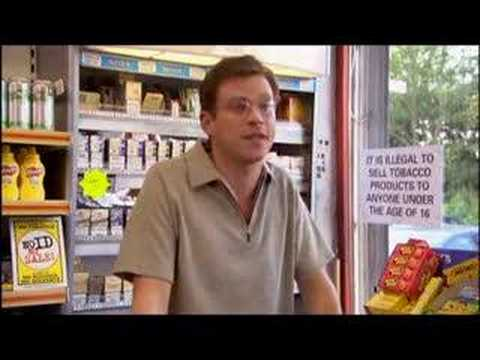

In [7]:
from IPython.display import YouTubeVideo
YouTubeVideo('zwXjm64a3QE')

In [8]:
# Two sided p-value
Ale_ratings = beers_RTC[beers_RTC['AleOrLager'] == 'Ale']['Rating']
Lager_ratings = beers_RTC[beers_RTC['AleOrLager'] == 'Lager']['Rating']

AL_t, AL_p = stats.ttest_ind(Ale_ratings,Lager_ratings, equal_var=False)
print('Two-sided t-test p-value Ale vs Lager: {:.3e}'.format(AL_p))

Two-sided t-test p-value Ale vs Lager: 2.292e-14


In [9]:
# FIXTHIS
# Add the bar plots for Ales, Lagers, and Ciders

### Find the top beers from a country

In [10]:
topoverall = beers_regions[['BeerName', 'Brewery', 'Country','Rating']][beers_regions['Rating'] >= 9]
topoverall = topoverall.sort_values(by=['Rating', 'Brewery'], ascending=[False, True])
topoverall

,BeerName,Brewery,Country,Rating
8,Cuvee des Jacobins Rouge,Bockor Brewery,Belgium,10
73,Red Poppy Ale,Lost Abbey,US,10
6,Duchesse de Bourgogne,Verhaeghe Vichte,Belgium,10
85,"The Kimmie, The Yink, and the Holy Gose",Anderson Valley,US,9
110,Barney Flats Oatmeal Stout,Anderson Valley,US,9
1,Oude Geuze Boon,Boon Brewery,Belgium,9
68,Ursa Major,Craftsman,US,9
386,Sahtea,Dogfish Head,US,9
679,Dirty Bastard,Founders Brewing Company,US,9
401,Harviestoun Ola Dubh (12 Year),Harviestoun Brewery,UK,9


In [11]:
countryOfInterest = 'US'
COI_beercount = 10

topfromreg = beers_regions[['BeerName', 'Brewery', 'Rating']][beers_regions['Country']==countryOfInterest]
topfromreg = topfromreg.sort_values(by='Rating', ascending=False)
topfromreg.head(COI_beercount)

,BeerName,Brewery,Rating
73,Red Poppy Ale,Lost Abbey,10
85,"The Kimmie, The Yink, and the Holy Gose",Anderson Valley,9
667,NOLA Against the Currant,NOLA,9
472,Reverend Nat's Hallelujah Hopricot,Reverend Nat's Hard Cider,9
110,Barney Flats Oatmeal Stout,Anderson Valley,9
68,Ursa Major,Craftsman,9
386,Sahtea,Dogfish Head,9
679,Dirty Bastard,Founders Brewing Company,9
482,BrightCider,2 Towns Ciderhouse,8
389,Punkin Ale,Dogfish Head,8


### Get country stats

In [12]:
country_thresh = 3

In [13]:
countrymean = beers_regions.groupby('Country')['Rating'].mean() 
countrymean.name = 'Mean'
countrystd = beers_regions.groupby('Country')['Rating'].std()
countrystd.name = 'StDev'
countrycount = beers_regions.groupby('Country')['Rating'].size()
countrycount.name = 'Count'

In [14]:
countrystats = pd.DataFrame(data=[countrymean, countrystd, countrycount]).transpose()
countrystats = countrystats[countrystats['Count'] >= country_thresh]
print(countrystats.ix['US']['Mean'])
countrystats.sort_values(by=['Mean', 'Count'], ascending=[False, True], inplace=True)
countrystats['Mean'] = countrystats['Mean'].map('{:,.2f}'.format)
countrystats['StDev'] = countrystats['StDev'].map('{:,.2f}'.format)
countrystats

6.0


,Mean,StDev,Count
Country,,,
Belgium,6.71,1.38,45.0
Lithuania,6.50,1.22,6.0
Brazil,6.00,1.00,3.0
US,6.00,1.43,264.0
UK,5.98,1.64,49.0
Japan,5.78,1.20,9.0
Italy,5.75,1.18,16.0
Spain,5.71,1.60,7.0
Mexico,5.56,1.67,9.0


#### Just doing ales and lagers independent

In [15]:
Acountry_thresh = 3
Lcountry_thresh = 3

Acountrymean = beers_RTC[beers_RTC['AleOrLager']=='Ale'].groupby('Country')['Rating'].mean() 
Acountrymean.name = 'Ale Mean'
Acountrystd = beers_RTC[beers_RTC['AleOrLager']=='Ale'].groupby('Country')['Rating'].std()
Acountrystd.name = 'Ale StDev'
Acountrycount = beers_RTC[beers_RTC['AleOrLager']=='Ale'].groupby('Country')['Rating'].size()
Acountrycount.name = 'Ale Count'

Lcountrymean = beers_RTC[beers_RTC['AleOrLager']=='Lager'].groupby('Country')['Rating'].mean() 
Lcountrymean.name = 'Lager Mean'
Lcountrystd = beers_RTC[beers_RTC['AleOrLager']=='Lager'].groupby('Country')['Rating'].std()
Lcountrystd.name = 'Lager StDev'
Lcountrycount = beers_RTC[beers_RTC['AleOrLager']=='Lager'].groupby('Country')['Rating'].size()
Lcountrycount.name = 'Lager Count'

In [16]:
Acountrystats = pd.DataFrame(data=[Acountrymean, Acountrystd, Acountrycount]).transpose()
Acountrystats = Acountrystats[Acountrystats['Ale Count'] >= Acountry_thresh]
Acountrystats.sort_values(by='Ale Mean', ascending=False, inplace=True)
Acountrystats['Ale Mean'] = Acountrystats['Ale Mean'].map('{:,.2f}'.format)
Acountrystats['Ale StDev'] = Acountrystats['Ale StDev'].map('{:,.2f}'.format)
Acountrystats

,Ale Mean,Ale StDev,Ale Count
Country,,,
Belgium,6.72,1.30,43.0
UK,6.28,1.77,36.0
Italy,6.20,1.30,5.0
US,6.06,1.44,191.0
Australia,6.00,1.00,3.0
Japan,6.00,1.63,4.0
Canada,5.54,1.81,13.0
Germany,5.45,1.44,11.0
Poland,5.33,1.21,6.0


In [17]:
Lcountrystats = pd.DataFrame(data=[Lcountrymean, Lcountrystd, Lcountrycount]).transpose()
Lcountrystats = Lcountrystats[Lcountrystats['Lager Count'] >= Lcountry_thresh]
Lcountrystats.sort_values(by='Lager Mean', ascending=False, inplace=True)
Lcountrystats['Lager Mean'] = Lcountrystats['Lager Mean'].map('{:,.2f}'.format)
Lcountrystats['Lager StDev'] = Lcountrystats['Lager StDev'].map('{:,.2f}'.format)
Lcountrystats

,Lager Mean,Lager StDev,Lager Count
Country,,,
Brazil,6.00,1.00,3.0
Lithuania,6.00,1.15,4.0
US,5.61,1.25,36.0
Russia,5.40,1.17,10.0
Italy,5.38,0.92,8.0
Japan,5.33,1.15,3.0
Germany,5.29,1.73,14.0
India,5.25,0.96,4.0
Austria,5.25,1.89,4.0


### US State/Canadian province statistics

In [18]:
state_thresh = 1

statemean = beers_regions[beers_regions['Country'].isin(['US', 'Canada'])].groupby('Origin')['Rating'].mean() 
statemean.name = 'Mean'
statestd = beers_regions[beers_regions['Country'].isin(['US', 'Canada'])].groupby('Origin')['Rating'].std()
statestd.name = 'StDev'
statecount = beers_regions[beers_regions['Country'].isin(['US', 'Canada'])].groupby('Origin')['Rating'].size()
statecount.name = 'Count'

In [19]:
statestats = pd.DataFrame(data=[statemean, statestd, statecount]).transpose()
statestats.index.names = ['State']
statestats = statestats[statestats['Count'] >= state_thresh]
statestats.sort_values(by='Mean', ascending=False, inplace=True)
statestats['Mean'] = statestats['Mean'].map('{:,.2f}'.format)
statestats['StDev'] = statestats['StDev'].map('{:,.2f}'.format)

statestats

,Mean,StDev,Count
State,,,
South Carolina,8.00,nan,1.0
Minnesota,8.00,nan,1.0
Alaska,7.20,0.84,5.0
Illinois,7.00,nan,1.0
Delaware,7.00,1.31,8.0
Washington,7.00,0.82,4.0
Michigan,6.40,2.30,5.0
Maryland,6.33,2.08,3.0
Oklahoma,6.33,1.53,3.0


### Get corporation stats

In [20]:
corp_thresh = 3

In [21]:
corpmean = beers_RTC.groupby('Corporation')['Rating'].mean() 
corpmean.name = 'Mean'
corpstd = beers_RTC.groupby('Corporation')['Rating'].std()
corpstd.name = 'StDev'
corpcount = beers_RTC.groupby('Corporation')['Rating'].size()
corpcount.name = 'Count'

# Beers that don't have a corporation listed are "craft/independent"
craftbeers = beers_RTC[beers_RTC['Corporation'].isnull()]
craftmean = craftbeers['Rating'].mean()
craftstd = craftbeers['Rating'].std()
craftcount = len(craftbeers['Rating'])

In [22]:
corpstats = pd.DataFrame(data=[corpmean, corpstd, corpcount]).transpose()
corpstats = corpstats[corpstats['Count'] >= corp_thresh]

# Get the list of corporations without the Craft/Independent
corplist = corpstats.reset_index(inplace=False)
corplist = corplist['Corporation']

corpstats.loc['Craft / Independent'] = [craftmean, craftstd, craftcount]
corpstats.sort_values(by='Mean', ascending=False, inplace=True)
corpstats['Mean'] = corpstats['Mean'].map('{:,.2f}'.format)
corpstats['StDev'] = corpstats['StDev'].map('{:,.2f}'.format)

In [23]:
craftratings = craftbeers['Rating']
corp_p_series = pd.Series([], name='Two-sided p')
for corp in corplist:
    corpratings = beers_RTC[beers_RTC['Corporation']==corp]['Rating']
    t, corp_p = stats.ttest_ind(craftratings,corpratings, equal_var=False)
    corp_p_series[corp] = corp_p

corpstats['Two-sided p'] = corp_p_series
corpstats['Two-sided p'] = corpstats['Two-sided p'].map('{:,.4f}'.format)
corpstats.replace('nan',' ', regex=True, inplace=True)

corpstats

,Mean,StDev,Count,Two-sided p
Corporation,,,,
Samuel Smith,7.30,1.25,10.0,0.0031
Moortgat,7.14,1.21,7.0,0.0209
Greene King,6.00,1.10,6.0,0.5624
Sapporo,6.00,1.85,8.0,0.6834
New Belgium,5.80,1.40,10.0,0.8624
Craft / Independent,5.72,1.52,479.0,
C&C Group,5.67,1.21,6.0,0.9186
AB / InBev,5.54,1.48,28.0,0.5262
Boston Beer Company,5.50,1.29,4.0,0.7563


#### Now, seperating ales and lagers

In [24]:
Acorp_thresh = 2
Lcorp_thresh = 2

Acorpmean = beers_RTC[beers_RTC['AleOrLager']=='Ale'].groupby('Corporation')['Rating'].mean() 
Acorpmean.name = 'Ale Mean'
Acorpstd = beers_RTC[beers_RTC['AleOrLager']=='Ale'].groupby('Corporation')['Rating'].std()
Acorpstd.name = 'Ale StDev'
Acorpcount = beers_RTC[beers_RTC['AleOrLager']=='Ale'].groupby('Corporation')['Rating'].size()
Acorpcount.name = 'Ale Count'

Acraftbeers = beers_RTC[beers_RTC['Corporation'].isnull()]
Acraftbeers = Acraftbeers[Acraftbeers['AleOrLager']=='Ale']
Acraftmean = Acraftbeers['Rating'].mean()
Acraftstd = Acraftbeers['Rating'].std()
Acraftcount = len(Acraftbeers['Rating'])

Lcorpmean = beers_RTC[beers_RTC['AleOrLager']=='Lager'].groupby('Corporation')['Rating'].mean() 
Lcorpmean.name = 'Lager Mean'
Lcorpstd = beers_RTC[beers_RTC['AleOrLager']=='Lager'].groupby('Corporation')['Rating'].std()
Lcorpstd.name = 'Lager StDev'
Lcorpcount = beers_RTC[beers_RTC['AleOrLager']=='Lager'].groupby('Corporation')['Rating'].size()
Lcorpcount.name = 'Lager Count'

Lcraftbeers = beers_RTC[beers_RTC['Corporation'].isnull()]
Lcraftbeers = Lcraftbeers[Lcraftbeers['AleOrLager']=='Lager']
Lcraftmean = Lcraftbeers['Rating'].mean()
Lcraftstd = Lcraftbeers['Rating'].std()
Lcraftcount = len(Lcraftbeers['Rating'])

In [25]:
Acorpstats = pd.DataFrame(data=[Acorpmean, Acorpstd, Acorpcount]).transpose()
Acorpstats = Acorpstats[Acorpstats['Ale Count'] >= Acorp_thresh]

# Get the list of corporations without the Craft/Independent
Acorplist = Acorpstats.reset_index(inplace=False)
Acorplist = Acorplist['Corporation']

Acorpstats.loc['Craft / Independent'] = [Acraftmean, Acraftstd, Acraftcount]
Acorpstats.sort_values(by='Ale Mean', ascending=False, inplace=True)
Acorpstats['Ale Mean'] = Acorpstats['Ale Mean'].map('{:,.2f}'.format)
Acorpstats['Ale StDev'] = Acorpstats['Ale StDev'].map('{:,.2f}'.format)

Acraftratings = Acraftbeers['Rating']
Acorp_p_series = pd.Series([], name='Two-sided p')
for corp in Acorplist:
    corpratings = beers_RTC[beers_RTC['Corporation']==corp]['Rating']
    t, corp_p = stats.ttest_ind(Acraftratings,corpratings, equal_var=False)
    Acorp_p_series[corp] = corp_p

Acorpstats['Two-sided p'] = Acorp_p_series
Acorpstats['Two-sided p'] = Acorpstats['Two-sided p'].map('{:,.4f}'.format)
Acorpstats.replace('nan',' ', regex=True, inplace=True)

Acorpstats

,Ale Mean,Ale StDev,Ale Count,Two-sided p
Corporation,,,,
Samuel Smith,7.33,1.32,9.0,0.0058
Moortgat,6.83,0.98,6.0,0.0331
AB / InBev,6.55,1.29,11.0,0.2479
Carlsberg,6.33,1.37,6.0,0.0107
Sapporo,6.33,1.97,6.0,0.8611
Greene King,6.00,1.10,6.0,0.8025
United Breweries Group,6.00,2.83,2.0,0.5687
Craft / Independent,5.88,1.55,309.0,
New Belgium,5.78,1.48,9.0,0.8624


In [26]:
Lcorpstats = pd.DataFrame(data=[Lcorpmean, Lcorpstd, Lcorpcount]).transpose()
Lcorpstats = Lcorpstats[Lcorpstats['Lager Count'] >= Lcorp_thresh]

# Get the list of corporations without the Craft/Independent
Lcorplist = Lcorpstats.reset_index(inplace=False)
Lcorplist = Lcorplist['Corporation']

Lcorpstats.loc['Craft / Independent'] = [Lcraftmean, Lcraftstd, Lcraftcount]
Lcorpstats.sort_values(by='Lager Mean', ascending=False, inplace=True)
Lcorpstats['Lager Mean'] = Lcorpstats['Lager Mean'].map('{:,.2f}'.format)
Lcorpstats['Lager StDev'] = Lcorpstats['Lager StDev'].map('{:,.2f}'.format)

Lcraftratings = Lcraftbeers['Rating']
Lcorp_p_series = pd.Series([], name='Two-sided p')
for corp in Lcorplist:
    corpratings = beers_RTC[beers_RTC['Corporation']==corp]['Rating']
    t, corp_p = stats.ttest_ind(Lcraftratings,corpratings, equal_var=False)
    Lcorp_p_series[corp] = corp_p

Lcorpstats['Two-sided p'] = Lcorp_p_series
Lcorpstats['Two-sided p'] = Lcorpstats['Two-sided p'].map('{:,.4f}'.format)
Lcorpstats.replace('nan',' ', regex=True, inplace=True)

Lcorpstats

,Lager Mean,Lager StDev,Lager Count,Two-sided p
Corporation,,,,
United Breweries Group,5.25,0.96,4.0,0.6652
Craft / Independent,5.21,1.42,114.0,
Carlsberg,5.00,1.55,31.0,0.9128
Castel,5.00,0.82,4.0,0.6518
Pabst Brewing Company,5.00,1.41,2.0,0.8681
Sapporo,5.00,1.41,2.0,0.2730
AB / InBev,4.88,1.22,17.0,0.2996
Heineken,4.48,1.27,23.0,0.1006
Royal Unibrew,4.44,1.13,9.0,0.0249


### Running date mean

In [27]:
# How many dates we look at for the running mean
date_slack = 7

first_date = dt.datetime.strptime(beers_RTC['Date'].min(), '%Y-%m-%d')
last_date  = dt.datetime.strptime(beers_RTC['Date'].max(), '%Y-%m-%d')

daterange = last_date-first_date

days_array = []
days_means = []
days_count = []
days_sum = []

for day_offset in range(0,daterange.days+1,1):
    filldate = (first_date + dt.timedelta(days=day_offset)).strftime('%Y-%m-%d')
    days_array.append(filldate)
    days_count.append(beers_RTC[beers_RTC['Date']==filldate]['Rating'].count())
    days_means.append(beers_RTC[beers_RTC['Date']==filldate]['Rating'].mean())
    days_sum.append(beers_RTC[beers_RTC['Date']==filldate]['Rating'].sum())

#testdate = pd.Series(['2014-11-02', '2014-11-03'])
#beers_RTC[any(beers_RTC['Date'] in testdate)]['Rating'].count()

In [28]:
# FIXTHIS:
# https://stackoverflow.com/questions/14300768/pandas-rolling-computation-with-window-based-on-values-instead-of-counts
# This theoretically shows me how to make a running mean. In practice, none of the solutions I've found online have been 
# particularly successful and so I'm just going to program this in the dumbest way possible. I'll try to get something
# fancier working some other time.

# Working with days_sum
days_sum_pad = days_sum.copy()
days_count_pad = days_count.copy()
for i in range(date_slack-1):
    days_sum_pad.insert(0, 0)
    days_count_pad.insert(0, 0)

len_days = len(days_sum)
days_sum_rn = np.zeros((len_days,))
days_count_rn = np.zeros((len_days,))
for i in range(date_slack):
    days_sum_rn = days_sum_rn + days_sum_pad[i:(i+len_days)]
    days_count_rn = days_count_rn + days_count_pad[i:(i+len_days)]
days_mean_rn = days_sum_rn/days_count_rn


In [29]:
days_df = pd.DataFrame({'Day': days_array, 'Daily Mean': days_means, 'Count': days_count, 'Running Mean': days_mean_rn})
days_df.set_index('Day', inplace=True)

[0, 539, 2, 10]

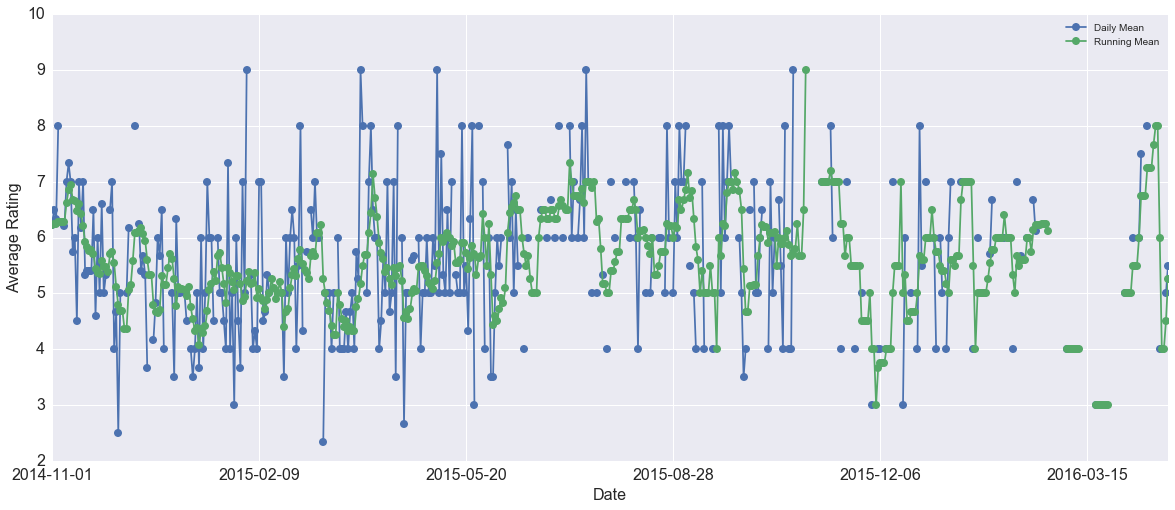

In [30]:
days_df[['Daily Mean', 'Running Mean']].plot(figsize=(20, 8), marker='o', markersize=8)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Rating', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.axis([0, daterange.days, 2, 10])

### How do I rate beers by how I drink them? (Glass/Bottle/Can)

In [31]:
## Let Beers_RTC be the more useful dataframe, I can futz with beers
beers['HowIDrank'] = beers['HowIDrank'].str.lower()

beers_glass = beers[beers['HowIDrank'].str.contains('glass')==True]
beers_bottle = beers[beers['HowIDrank'].str.contains('bottle')==True]
beers_can = beers[beers['HowIDrank'].str.contains('can')==True]

In [32]:
GBC_mean = [beers_glass['Rating'].mean(), beers_bottle['Rating'].mean(), beers_can['Rating'].mean()]
GBC_std = [beers_glass['Rating'].std(), beers_bottle['Rating'].std(), beers_can['Rating'].std()]
GBC_count = [beers_glass['Rating'].count(), beers_bottle['Rating'].count(), beers_can['Rating'].count()]

GBC_df = pd.DataFrame({'Style':['Glass', 'Bottle', 'Can'], 'Mean':GBC_mean, 'StDev':GBC_std, 'Count':GBC_count})
GBC_df['Mean'] = GBC_df['Mean'].map('{:,.2f}'.format)
GBC_df['StDev'] = GBC_df['StDev'].map('{:,.2f}'.format)
GBC_df.set_index('Style', inplace=True)
GBC_df

,Count,Mean,StDev
Style,,,
Glass,178,5.90,1.38
Bottle,414,5.57,1.57
Can,85,5.02,1.53


In [33]:
H_GBC, p_GBC = stats.kruskal(beers_glass['Rating'], beers_bottle['Rating'], beers_can['Rating'])
print('Kruskal-Wallis p-value for Glass/Bottle/Can: {:.3e}'.format(p_GBC))

Kruskal-Wallis p-value for Glass/Bottle/Can: 3.599e-05


### ABV versus Rating

In [34]:
ABVvals = beers[['ABV', 'Rating']]
ABVvals.dropna(subset=['ABV','Rating'], inplace=True)
# ABVvals.plot(kind='scatter', x='ABV', y='Rating', figsize=(16,6))
# I'd love to make the dots have a radius that goes with the number at an entry

/Users/anzelp/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [35]:
ABVslope, ABVintercept, ABVr_value, ABVp_value, ABVstd_err = stats.linregress(ABVvals['ABV'], ABVvals['Rating'])
(ABVslope, ABVintercept, ABVr_value, ABVp_value, ABVstd_err)

(0.14817849958872201,
 4.7090390684684946,
 0.17125876429007469,
 7.3170283524018984e-06,
 0.032786491118204954)

<function matplotlib.pyplot.show>

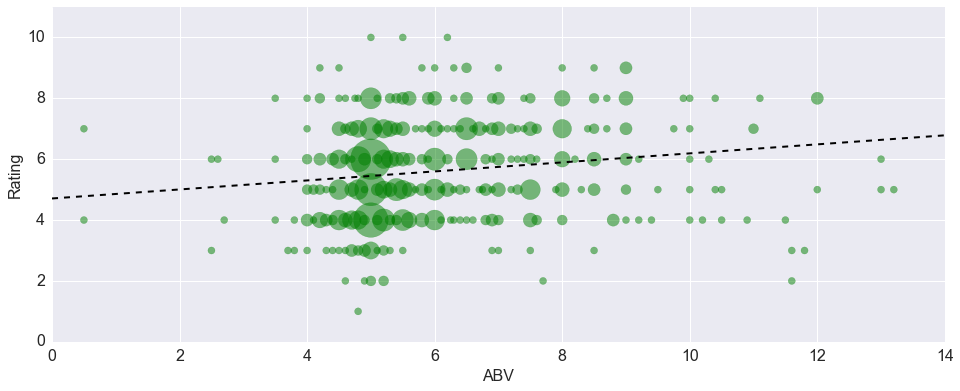

In [36]:
size_factor_for_ABVscatter = 50

listcounts = ABVvals.groupby(['ABV', 'Rating']).size()
ABV_list = []
ABV_rats = []
ABV_count = []
for val in listcounts.index.values:
    xABV, yABV = val
    ABV_list.append(xABV)
    ABV_rats.append(yABV)
for countin in listcounts:
    ABV_count.append(countin)
# print(ABV_list)
# print(ABV_rats)
# print(ABV_count)
ABV_list=np.array(ABV_list)
ABV_rats=np.array(ABV_rats)
ABV_count=size_factor_for_ABVscatter*np.array(ABV_count)

ABV_fit_x = np.linspace(0, 14, num=100)
ABV_fit_y = ABVintercept+ABVslope*ABV_fit_x

plt.figure(figsize=(16, 6))
plt.scatter(ABV_list, ABV_rats, s=ABV_count, alpha=0.5, color='g')
plt.plot(ABV_fit_x, ABV_fit_y, 'k--', linewidth=2)
plt.axis([0, 14, 0, 11])
plt.xlabel('ABV', fontsize=16)
plt.ylabel('Rating', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show

### Graveyard of code

In [ ]:
# Trying to do the ABV plot with a meshgrid, didn't get this to work properly

# ABVvalsarray = ABVvals.reset_index().values
# ratings_bins = np.arange(.5, 10.5, 1)
# ABV_bins = np.arange(np.floor(ABVvalsarray[:,1].min())-.1, np.ceil(ABVvalsarray[:,1].max())+.1, .2)
# ABVh2d = np.histogram2d(ABVvalsarray[:,1], ABVvalsarray[:,2], bins = [ABV_bins, ratings_bins])
# figABV = plt.figure(figsize=(16,6))
# ax = figABV.add_subplot(111)
# X, Y = np.meshgrid(ABV_bins, ratings_bins)
# ax.pcolormesh(X, Y, ABVh2d)

In [ ]:
# ALcountrystats = pd.DataFrame(data=[Acountrymean, Acountrystd, Acountrycount, Lcountrymean, Lcountrystd, Lcountrycount]).transpose()

# ALcountrystats = ALcountrystats[(ALcountrystats['Ale Count'] >= Acountry_thresh) | (ALcountrystats['Lager Count'] >= Lcountry_thresh)]
# ALcountrystats.sort_index(by=['Ale Mean', 'Lager Mean'], ascending=[False, False], inplace=True)

# ALcountrystats['Ale Mean'] = ALcountrystats['Ale Mean'].map('{:,.2f}'.format)
# ALcountrystats['Ale StDev'] = ALcountrystats['Ale StDev'].map('{:,.2f}'.format)
# ALcountrystats['Lager Mean'] = ALcountrystats['Lager Mean'].map('{:,.2f}'.format)
# ALcountrystats['Lager StDev'] = ALcountrystats['Lager StDev'].map('{:,.2f}'.format)
# ALcountrystats.replace(np.nan,' ', regex=True, inplace=True)
# ALcountrystats.replace('nan',' ', regex=True, inplace=True)

# ALcountrystats

In [ ]:
# def rollBy(what, basis, window, func):
#     def applyToWindow(val):
#         chunk = what[(val<=basis) & (basis<val+window)]
#         return func(chunk)
#     return basis.apply(applyToWindow)

In [ ]:
# beers_RTC_simp = beers_RTC[['Date', 'Rating']]
# beers_RTC_simp['Date'] = beers_RTC_simp.Date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
# # beers_RTC_simp.set_index('Date', inplace=True)
# rollBy(beers_RTC_simp.Rating, beers_RTC_simp.Date, dt.timedelta(5), np.mean)